In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.models import Sequential
from keras.layers import Dense,  LSTM,  Dropout
%matplotlib inline
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from plot_keras_history import plot_history

Using TensorFlow backend.
C:\home\anaconda\envs\TF\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
path = os.getcwd()
print(path)

C:\home\program


In [3]:
os.chdir('../')

# data

In [4]:
iwate = pd.read_csv('program/Stock2/stock2.csv', encoding="shift_jis")
iwate['day'] = pd.to_datetime(iwate['day'], format='%Y/%m/%d')
tottori = pd.read_csv('program/Stock2/stock2-tottori.csv', encoding="shift_jis")
tottori['day'] = pd.to_datetime(tottori['day'], format='%Y/%m/%d')
akita = pd.read_csv('program/Stock2/stock2-akita.csv', encoding="shift_jis")
akita['day'] = pd.to_datetime(akita['day'], format='%Y/%m/%d')
yamagata = pd.read_csv('program/Stock2/stock2-yamagata.csv', encoding="shift_jis")
yamagata['day'] = pd.to_datetime(yamagata['day'], format='%Y/%m/%d')
ehime = pd.read_csv('program/Stock2/stock2-ehime.csv', encoding="shift_jis")
ehime['day'] = pd.to_datetime(ehime['day'], format='%Y/%m/%d')

In [5]:
def ema(milktea, period):
    ema = np.zeros(len(milktea))
    ema[:] = np.nan # NaN で一旦初期化
    ema[period-1] = milktea[:period].mean() # 最初だけ単純移動平均で算出
    
    for day in range(period, len(milktea)):
        ema[day] = ema[day-1] + (milktea[day] - ema[day-1]) / (period + 1) * 2
    
    return ema

In [6]:
iwate.set_index('day')
dateTimeIndex = pd.DatetimeIndex(iwate['day'])
iwate.index = dateTimeIndex

In [7]:
tottori.set_index('day')
dateTimeIndex = pd.DatetimeIndex(tottori['day'])
tottori.index = dateTimeIndex

In [8]:
akita.set_index('day')
dateTimeIndex = pd.DatetimeIndex(akita['day'])
akita.index = dateTimeIndex

In [9]:
yamagata.set_index('day')
dateTimeIndex = pd.DatetimeIndex(yamagata['day'])
yamagata.index = dateTimeIndex

In [10]:
ehime.set_index('day')
dateTimeIndex = pd.DatetimeIndex(ehime['day'])
ehime.index = dateTimeIndex

In [11]:
TimeIndex = pd.date_range("2019-10-02", periods=367, freq="D")
TimeIndex2 = pd.date_range("2020-01-15", periods=262, freq="D")

In [12]:
iwate = iwate['2019-10-02':'2020-10-02']

In [13]:
iwate = iwate.resample('D').interpolate()
tottori = tottori.resample('D').interpolate()
akita = akita.resample('D').interpolate()
yamagata = yamagata.resample('D').interpolate()
ehime = ehime.resample('D').interpolate()

In [14]:
iwate.drop("day", axis=1)
tottori.drop("day", axis=1)
akita.drop("day", axis=1)
yamagata.drop("day", axis=1)
ehime.drop("day", axis=1)

,start,hight,low,end
day,,,,
2019-10-02,1082.000000,1120.000000,1078.000000,1117.0
2019-10-03,1095.000000,1097.000000,1078.000000,1097.0
2019-10-04,1084.000000,1091.000000,1075.000000,1090.0
2019-10-05,1085.666667,1090.666667,1074.666667,1087.0
2019-10-06,1087.333333,1090.333333,1074.333333,1084.0
...,...,...,...,...
2020-09-28,1203.000000,1205.000000,1187.000000,1204.0
2020-09-29,1199.000000,1219.000000,1185.000000,1207.0
2020-09-30,1200.000000,1201.000000,1178.000000,1180.0


In [15]:
S_iwate = iwate['end'].astype(int)
S_tottori = tottori['end'].astype(int)
S_akita = akita['end'].astype(int)
S_ehime = ehime['end'].astype(int)
S_yamagata = yamagata['end'].astype(int)

In [16]:
S_iwate["指数移動平均(30)"]=pd.Series(ema(S_iwate, 30).round(1))
S_tottori["指数移動平均(30)"]=pd.Series(ema(S_tottori, 30).round(1))
S_akita["指数移動平均(30)"]=pd.Series(ema(S_akita, 30).round(1))
S_ehime["指数移動平均(30)"]=pd.Series(ema(S_ehime, 30).round(1))
S_yamagata["指数移動平均(30)"]=pd.Series(ema(S_yamagata, 30).round(1))

# 岩手

In [17]:
L = len(iwate)
Y = iwate.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [18]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [19]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [20]:
scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [21]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [22]:
len(X)

364

In [23]:
# train, testデータを定義
X_train = X[:102, :, :]
X_test = X[102:, :, :]
Y_train = Y[:102, :]
Y_test = Y[102:, :]

In [24]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 1s - loss: 0.4286 - mean_absolute_error: 0.6429
Epoch 2/50
 - 0s - loss: 0.3800 - mean_absolute_error: 0.6050
Epoch 3/50
 - 0s - loss: 0.3457 - mean_absolute_error: 0.5764
Epoch 4/50
 - 0s - loss: 0.3163 - mean_absolute_error: 0.5510
Epoch 5/50
 - 0s - loss: 0.2908 - mean_absolute_error: 0.5281
Epoch 6/50
 - 0s - loss: 0.2662 - mean_absolute_error: 0.5047
Epoch 7/50
 - 0s - loss: 0.2435 - mean_absolute_error: 0.4824
Epoch 8/50
 - 0s - loss: 0.2222 - mean_absolute_error: 0.4603
Epoch 9/50
 - 0s - loss: 0.2020 - mean_absolute_error: 0.4384
Epoch 10/50
 - 0s - loss: 0.1834 - mean_absolute_error: 0.4174
Epoch 11/50
 - 0s - loss: 0.1651 - mean_absolute_error: 0.3952
Epoch 12/50
 - 0s - loss: 0.1479 - mean_absolute_error: 0.3735
Epoch 13/50
 - 0s - loss: 0.1315 - mean_absolute_error: 0.3513
Epoch 14/50
 - 0s - loss: 0.1164 - mean_absolute_error: 0.3302
Epoch 15/50
 - 0s - loss: 0.1016 - mean_absolute_error: 0.3075
Epoch 16/50
 - 0s - loss: 0.0884 - mean_absolute_error: 0.2858
E

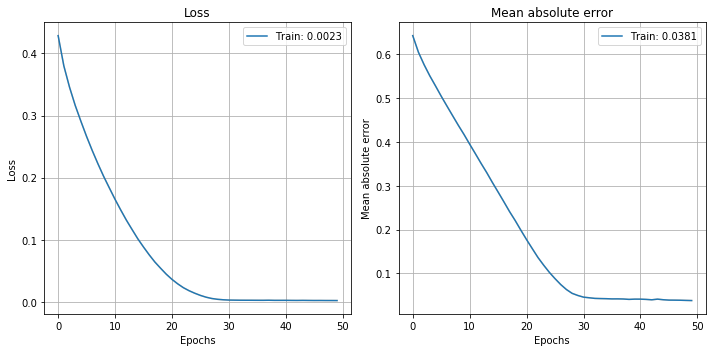

In [25]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_iwate = model.predict(X_test)

In [26]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(iwate.iloc[3:105,0])

In [27]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(iwate.iloc[105:,0])

In [28]:
P_iwate = scaler1.inverse_transform(P_iwate)
P_iwate = pd.DataFrame(P_iwate)
P_iwate.index=pd.to_datetime(iwate.iloc[105:,0])

In [29]:
P_iwate.index = TimeIndex2
Y_test.index = TimeIndex2
T_iwate = Y_test

# 鳥取

In [30]:
L = len(tottori)
Y = tottori.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [31]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [32]:
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [33]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [34]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [35]:
# train, testデータを定義
X_train = X[:102, :, :]
X_test = X[102:, :, :]
Y_train = Y[:102, :]
Y_test = Y[102:, :]

In [36]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 1s - loss: 1.0384 - mean_absolute_error: 1.0172
Epoch 2/50
 - 0s - loss: 0.9525 - mean_absolute_error: 0.9741
Epoch 3/50
 - 0s - loss: 0.8944 - mean_absolute_error: 0.9440
Epoch 4/50
 - 0s - loss: 0.8437 - mean_absolute_error: 0.9168
Epoch 5/50
 - 0s - loss: 0.7978 - mean_absolute_error: 0.8915
Epoch 6/50
 - 0s - loss: 0.7544 - mean_absolute_error: 0.8667
Epoch 7/50
 - 0s - loss: 0.7134 - mean_absolute_error: 0.8429
Epoch 8/50
 - 0s - loss: 0.6732 - mean_absolute_error: 0.8188
Epoch 9/50
 - 0s - loss: 0.6341 - mean_absolute_error: 0.7946
Epoch 10/50
 - 0s - loss: 0.5961 - mean_absolute_error: 0.7703
Epoch 11/50
 - 0s - loss: 0.5590 - mean_absolute_error: 0.7459
Epoch 12/50
 - 0s - loss: 0.5227 - mean_absolute_error: 0.7213
Epoch 13/50
 - 0s - loss: 0.4876 - mean_absolute_error: 0.6967
Epoch 14/50
 - 0s - loss: 0.4531 - mean_absolute_error: 0.6714
Epoch 15/50
 - 0s - loss: 0.4202 - mean_absolute_error: 0.6466
Epoch 16/50
 - 0s - loss: 0.3874 - mean_absolute_error: 0.6207
E

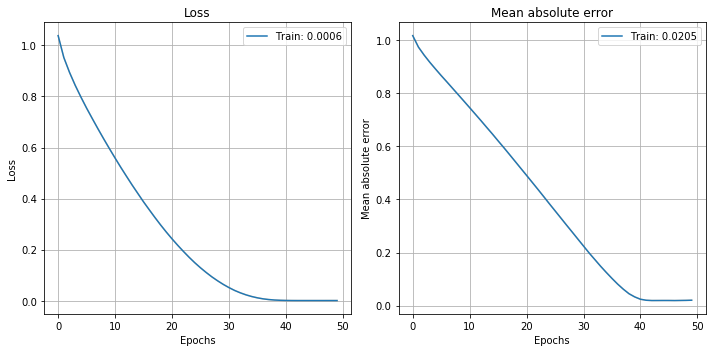

In [37]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_tottori = model.predict(X_test)

In [38]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(tottori.iloc[3:105,0])

In [39]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(tottori.iloc[105:,0])

In [40]:
P_tottori = scaler1.inverse_transform(P_tottori)
P_tottori = pd.DataFrame(P_tottori)
P_tottori.index=pd.to_datetime(tottori.iloc[105:,0])

In [41]:
P_tottori.index = TimeIndex2
Y_test.index = TimeIndex2
T_tottori = Y_test

# 秋田

In [42]:
L = len(akita)
Y = akita.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [43]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [44]:
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [45]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [46]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [47]:
# train, testデータを定義
X_train = X[:102, :, :]
X_test = X[102:, :, :]
Y_train = Y[:102, :]
Y_test = Y[102:, :]

In [48]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 1s - loss: 0.6564 - mean_absolute_error: 0.8083
Epoch 2/50
 - 0s - loss: 0.5943 - mean_absolute_error: 0.7692
Epoch 3/50
 - 0s - loss: 0.5514 - mean_absolute_error: 0.7407
Epoch 4/50
 - 0s - loss: 0.5153 - mean_absolute_error: 0.7160
Epoch 5/50
 - 0s - loss: 0.4819 - mean_absolute_error: 0.6924
Epoch 6/50
 - 0s - loss: 0.4508 - mean_absolute_error: 0.6696
Epoch 7/50
 - 0s - loss: 0.4205 - mean_absolute_error: 0.6467
Epoch 8/50
 - 0s - loss: 0.3917 - mean_absolute_error: 0.6240
Epoch 9/50
 - 0s - loss: 0.3644 - mean_absolute_error: 0.6019
Epoch 10/50
 - 0s - loss: 0.3374 - mean_absolute_error: 0.5790
Epoch 11/50
 - 0s - loss: 0.3120 - mean_absolute_error: 0.5567
Epoch 12/50
 - 0s - loss: 0.2878 - mean_absolute_error: 0.5345
Epoch 13/50
 - 0s - loss: 0.2636 - mean_absolute_error: 0.5115
Epoch 14/50
 - 0s - loss: 0.2407 - mean_absolute_error: 0.4886
Epoch 15/50
 - 0s - loss: 0.2186 - mean_absolute_error: 0.4655
Epoch 16/50
 - 0s - loss: 0.1977 - mean_absolute_error: 0.4426
E

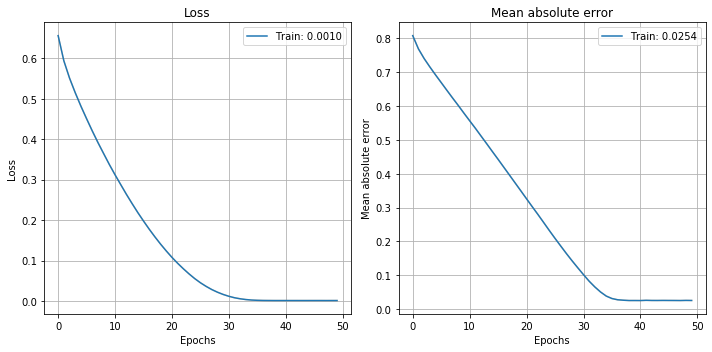

In [49]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_akita = model.predict(X_test)

In [50]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(akita.iloc[3:105,0])

In [51]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(akita.iloc[105:,0])

In [52]:
P_akita = scaler1.inverse_transform(P_akita)
P_akita = pd.DataFrame(P_akita)
P_akita.index=pd.to_datetime(akita.iloc[105:,0])

In [53]:
P_akita.index = TimeIndex2
Y_test.index = TimeIndex2
T_akita = Y_test

# 山形

In [54]:
L = len(yamagata)
Y = yamagata.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [55]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [56]:
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [57]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [58]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [59]:
# train, testデータを定義
X_train = X[:102, :, :]
X_test = X[102:, :, :]
Y_train = Y[:102, :]
Y_test = Y[102:, :]

In [60]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 1s - loss: 0.6779 - mean_absolute_error: 0.8190
Epoch 2/50
 - 0s - loss: 0.6298 - mean_absolute_error: 0.7893
Epoch 3/50
 - 0s - loss: 0.5970 - mean_absolute_error: 0.7682
Epoch 4/50
 - 0s - loss: 0.5681 - mean_absolute_error: 0.7493
Epoch 5/50
 - 0s - loss: 0.5416 - mean_absolute_error: 0.7315
Epoch 6/50
 - 0s - loss: 0.5163 - mean_absolute_error: 0.7141
Epoch 7/50
 - 0s - loss: 0.4918 - mean_absolute_error: 0.6969
Epoch 8/50
 - 0s - loss: 0.4680 - mean_absolute_error: 0.6797
Epoch 9/50
 - 0s - loss: 0.4441 - mean_absolute_error: 0.6620
Epoch 10/50
 - 0s - loss: 0.4204 - mean_absolute_error: 0.6438
Epoch 11/50
 - 0s - loss: 0.3972 - mean_absolute_error: 0.6258
Epoch 12/50
 - 0s - loss: 0.3746 - mean_absolute_error: 0.6075
Epoch 13/50
 - 0s - loss: 0.3522 - mean_absolute_error: 0.5889
Epoch 14/50
 - 0s - loss: 0.3301 - mean_absolute_error: 0.5700
Epoch 15/50
 - 0s - loss: 0.3081 - mean_absolute_error: 0.5504
Epoch 16/50
 - 0s - loss: 0.2870 - mean_absolute_error: 0.5310
E

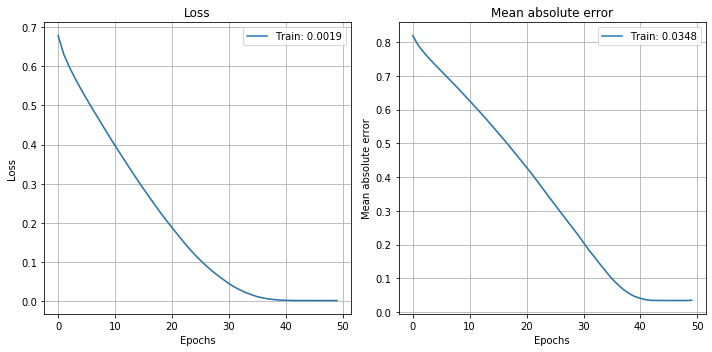

In [61]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_yamagata = model.predict(X_test)

In [62]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(yamagata.iloc[3:105,0])

In [63]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(yamagata.iloc[105:,0])

In [64]:
P_yamagata = scaler1.inverse_transform(P_yamagata)
P_yamagata = pd.DataFrame(P_yamagata)
P_yamagata.index=pd.to_datetime(yamagata.iloc[105:,0])

In [65]:
P_yamagata.index = TimeIndex2
Y_test.index = TimeIndex2
T_yamagata = Y_test

# 愛媛

In [66]:
L = len(ehime)
Y = ehime.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [67]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [68]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [69]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [70]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [71]:
# train, testデータを定義
X_train = X[:102, :, :]
X_test = X[102:, :, :]
Y_train = Y[:102, :]
Y_test = Y[102:, :]

In [72]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 1s - loss: 0.3997 - mean_absolute_error: 0.6229
Epoch 2/50
 - 0s - loss: 0.3450 - mean_absolute_error: 0.5785
Epoch 3/50
 - 0s - loss: 0.3091 - mean_absolute_error: 0.5469
Epoch 4/50
 - 0s - loss: 0.2791 - mean_absolute_error: 0.5193
Epoch 5/50
 - 0s - loss: 0.2526 - mean_absolute_error: 0.4936
Epoch 6/50
 - 0s - loss: 0.2290 - mean_absolute_error: 0.4696
Epoch 7/50
 - 0s - loss: 0.2069 - mean_absolute_error: 0.4459
Epoch 8/50
 - 0s - loss: 0.1860 - mean_absolute_error: 0.4224
Epoch 9/50
 - 0s - loss: 0.1662 - mean_absolute_error: 0.3989
Epoch 10/50
 - 0s - loss: 0.1477 - mean_absolute_error: 0.3754
Epoch 11/50
 - 0s - loss: 0.1302 - mean_absolute_error: 0.3515
Epoch 12/50
 - 0s - loss: 0.1141 - mean_absolute_error: 0.3285
Epoch 13/50
 - 0s - loss: 0.0989 - mean_absolute_error: 0.3049
Epoch 14/50
 - 0s - loss: 0.0849 - mean_absolute_error: 0.2817
Epoch 15/50
 - 0s - loss: 0.0718 - mean_absolute_error: 0.2580
Epoch 16/50
 - 0s - loss: 0.0608 - mean_absolute_error: 0.2360
E

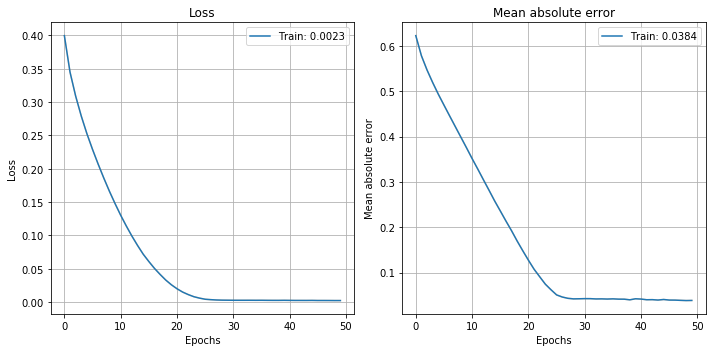

In [73]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_ehime = model.predict(X_test)

In [74]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(ehime.iloc[3:105,0])

In [75]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(ehime.iloc[105:,0])

In [76]:
P_ehime = scaler1.inverse_transform(P_ehime)
P_ehime = pd.DataFrame(P_ehime)
P_ehime.index=pd.to_datetime(ehime.iloc[105:,0])

In [77]:
P_ehime.index = TimeIndex2
Y_test.index = TimeIndex2
T_ehime = Y_test

# plot

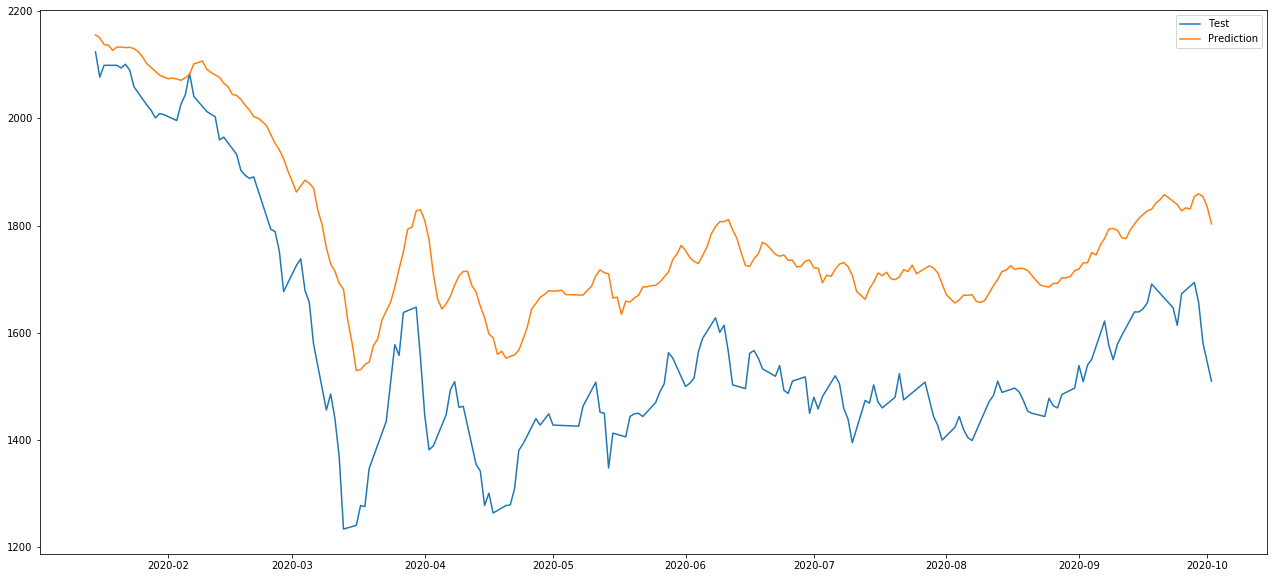

In [78]:
plt.figure(figsize=(22,10))
plt.plot(T_akita, label = 'Test')
plt.plot(P_akita, label = 'Prediction')
plt.legend(loc='best')
plt.show()

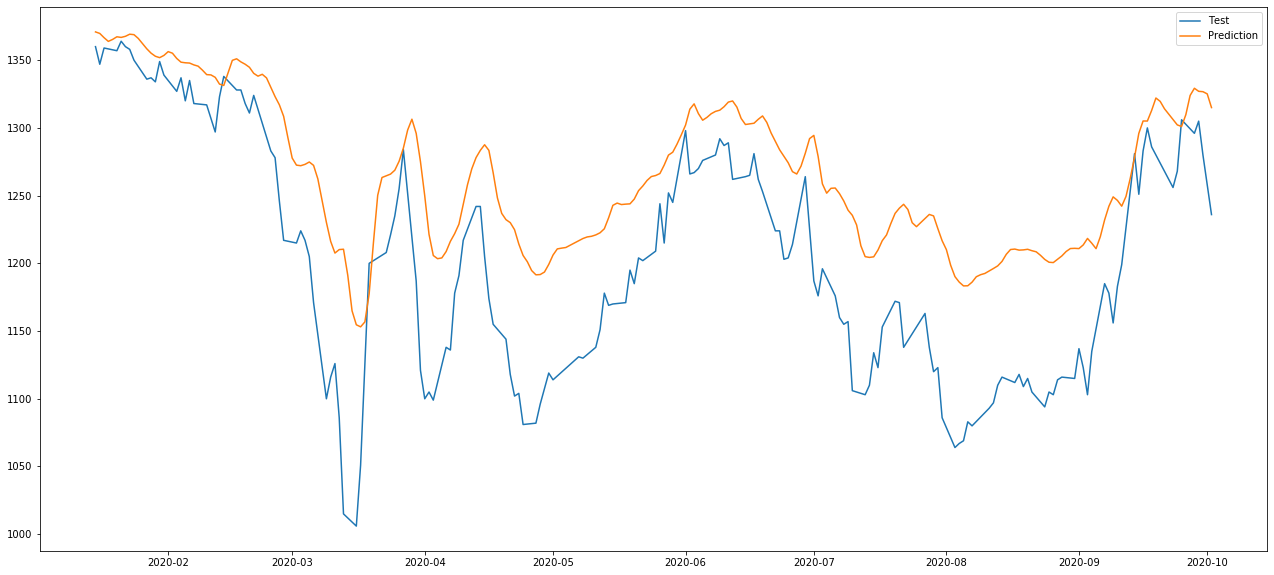

In [79]:
plt.figure(figsize=(22,10))
plt.plot(T_tottori, label = 'Test')
plt.plot(P_tottori, label = 'Prediction')
plt.legend(loc='best')
plt.show()

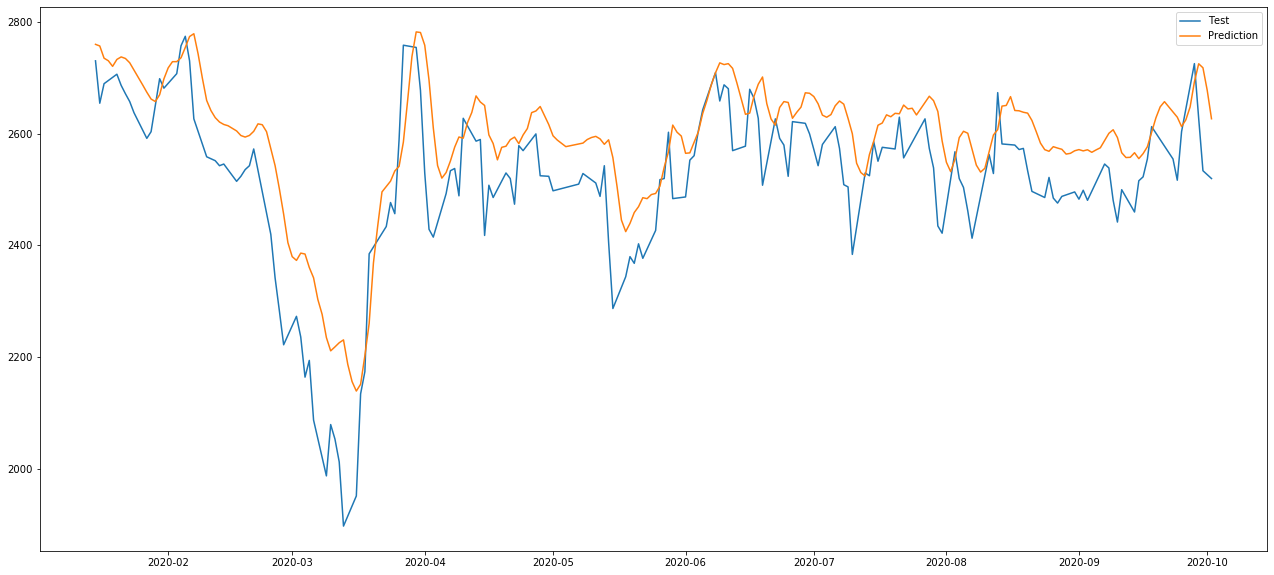

In [80]:
plt.figure(figsize=(22,10))
plt.plot(T_iwate, label = 'Test')
plt.plot(P_iwate, label = 'Prediction')
plt.legend(loc='best')
plt.show()

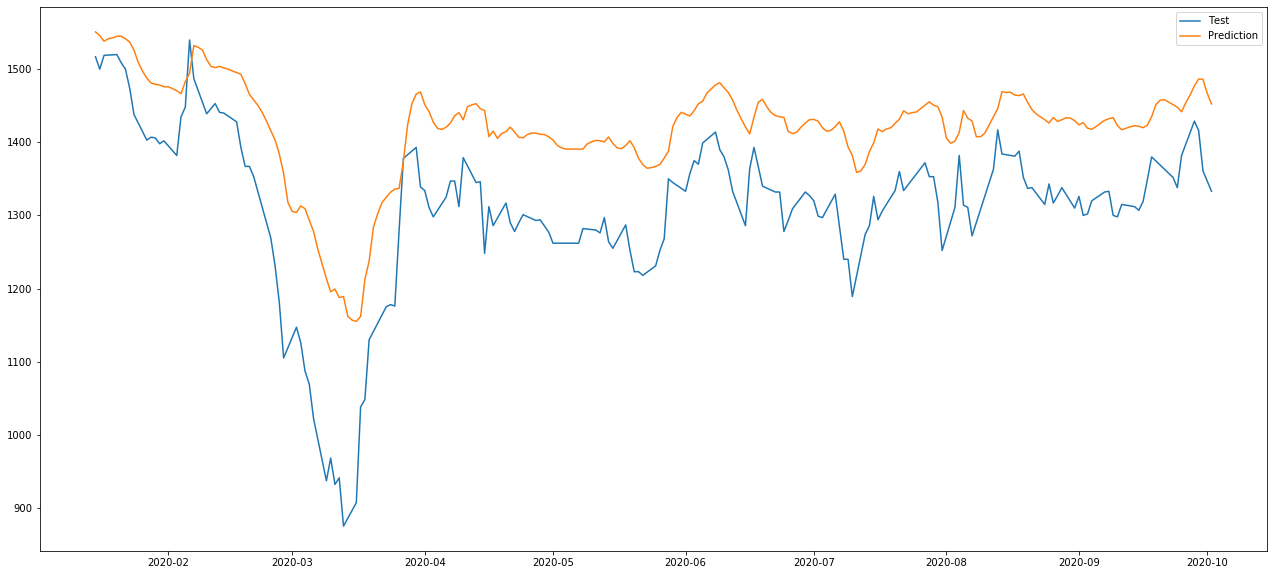

In [81]:
plt.figure(figsize=(22,10))
plt.plot(T_yamagata, label = 'Test')
plt.plot(P_yamagata, label = 'Prediction')
plt.legend(loc='best')
plt.show()

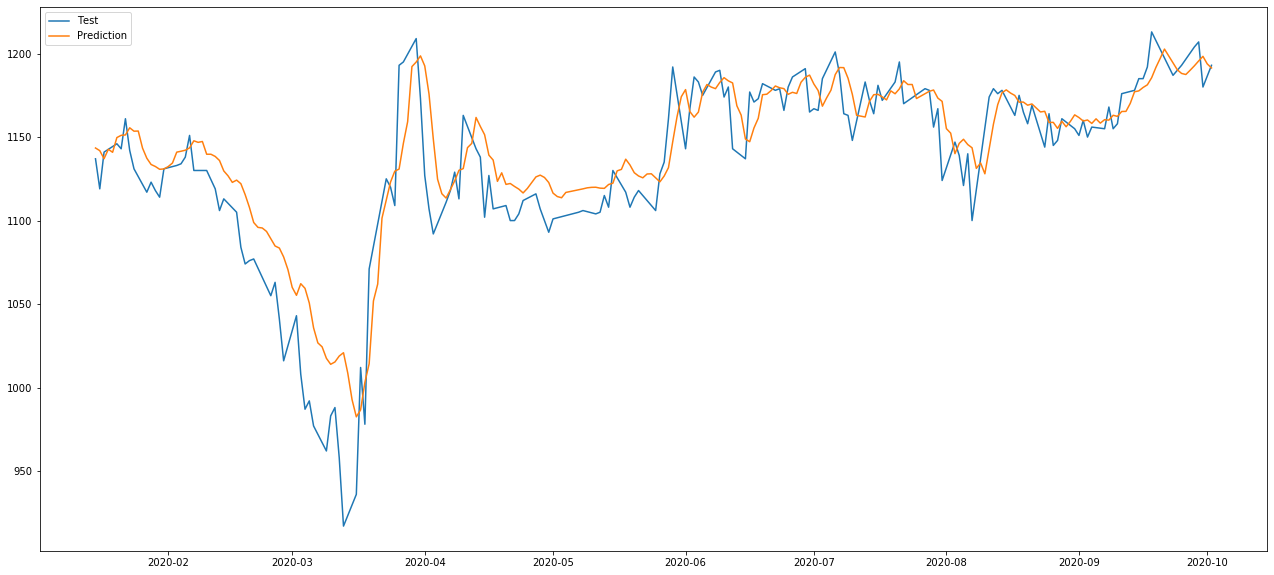

In [82]:
plt.figure(figsize=(22,10))
plt.plot(T_ehime, label = 'Test')
plt.plot(P_ehime, label = 'Prediction')
plt.legend(loc='best')
plt.show()

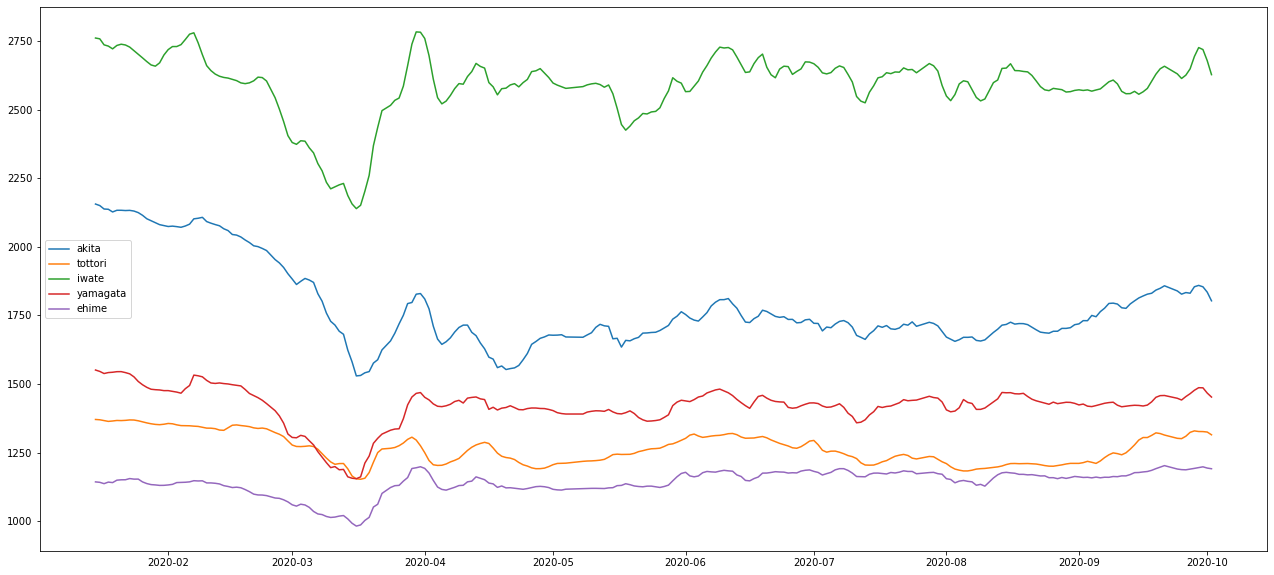

In [83]:
plt.figure(figsize=(22,10))
plt.plot(P_akita, label = 'akita')
plt.plot(P_tottori, label = 'tottori')
plt.plot(P_iwate, label = 'iwate')
plt.plot(P_yamagata, label = 'yamagata')
plt.plot(P_ehime, label = 'ehime')
plt.legend(loc='best')
plt.show()

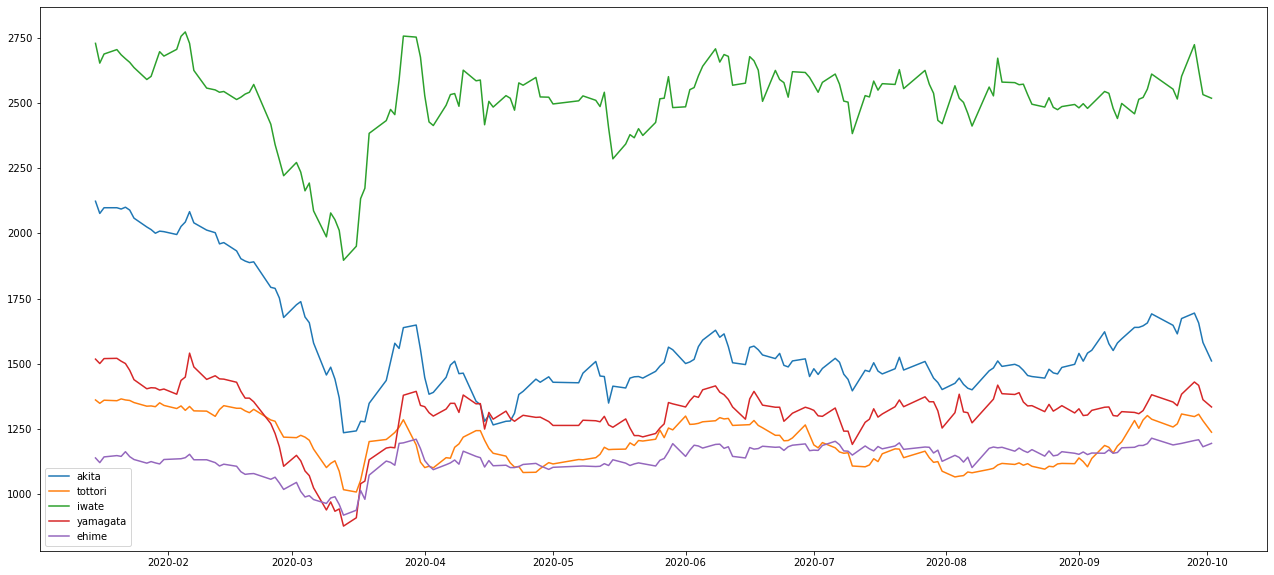

In [84]:
plt.figure(figsize=(22,10))
plt.plot(T_akita, label = 'akita')
plt.plot(T_tottori, label = 'tottori')
plt.plot(T_iwate, label = 'iwate')
plt.plot(T_yamagata, label = 'yamagata')
plt.plot(T_ehime, label = 'ehime')
plt.legend(loc='best')
plt.show()

In [85]:
P_akita['diff']=P_akita.diff()
P_tottori['diff']=P_tottori.diff()
P_iwate['diff']=P_iwate.diff()
P_yamagata['diff']=P_yamagata.diff()
P_ehime['diff']=P_ehime.diff()

In [86]:
T_akita['diff'] = T_akita.diff()
T_tottori['diff'] = T_tottori.diff()
T_iwate['diff'] = T_iwate.diff()
T_yamagata['diff'] = T_yamagata.diff()
T_ehime['diff'] = T_ehime.diff()

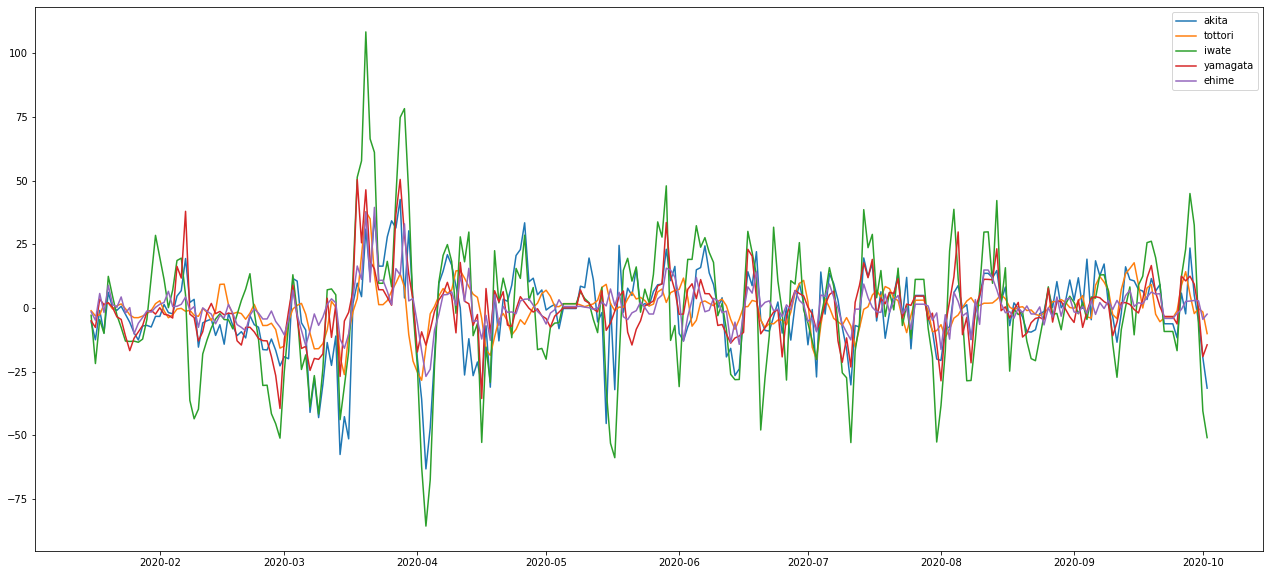

In [87]:
plt.figure(figsize=(22,10))
plt.plot(P_akita['diff'], label = 'akita')
plt.plot(P_tottori['diff'], label = 'tottori')
plt.plot(P_iwate['diff'], label = 'iwate')
plt.plot(P_yamagata['diff'], label = 'yamagata')
plt.plot(P_ehime['diff'], label = 'ehime')
plt.savefig('P_worst5.png')
plt.legend(loc='best')
plt.show()

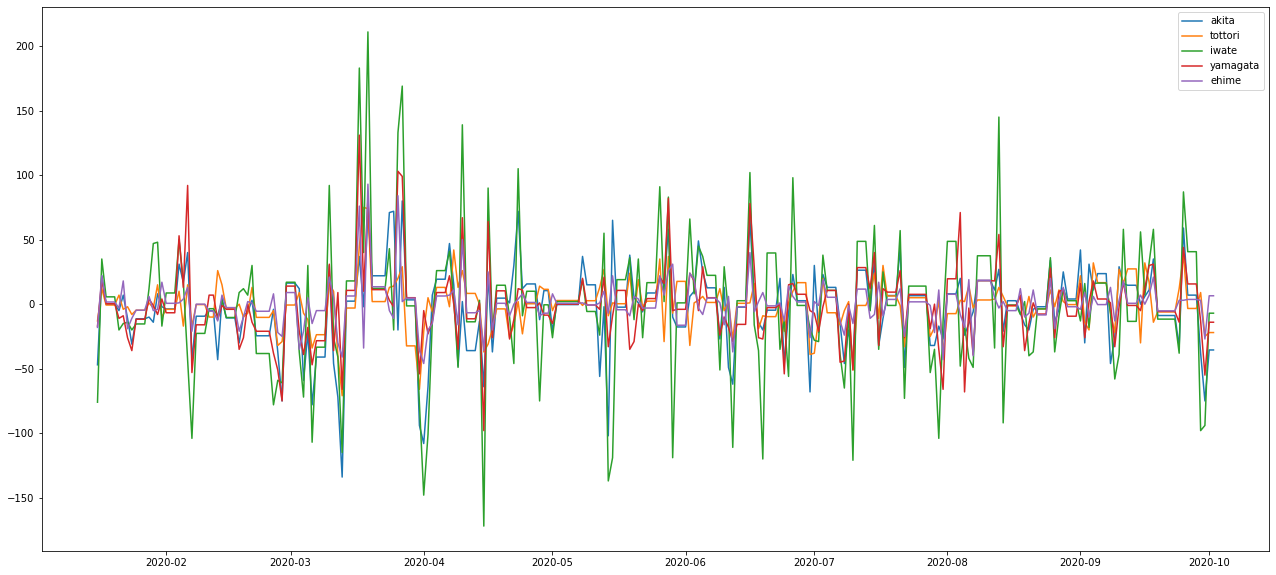

In [88]:
plt.figure(figsize=(22,10))
plt.plot(T_akita['diff'], label = 'akita')
plt.plot(T_tottori['diff'], label = 'tottori')
plt.plot(T_iwate['diff'], label = 'iwate')
plt.plot(T_yamagata['diff'], label = 'yamagata')
plt.plot(T_ehime['diff'], label = 'ehime')
plt.savefig('worst5.png')
plt.legend(loc='best')
plt.show()

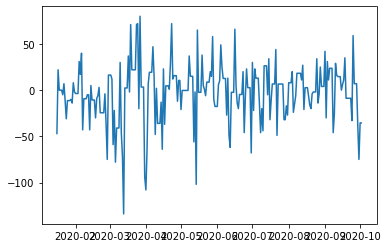

In [89]:
plt.plot(T_akita['diff'], label = 'akita')
plt.savefig('akita.png')

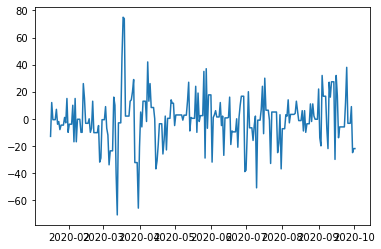

In [90]:
plt.plot(T_tottori['diff'], label = 'tottori')
plt.savefig('tottori.png')

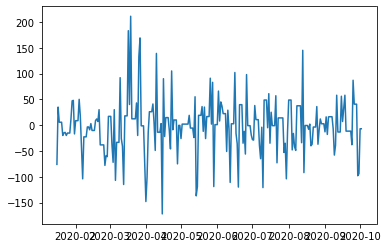

In [91]:
plt.plot(T_iwate['diff'], label = 'iwate')
plt.savefig('iwate.png')

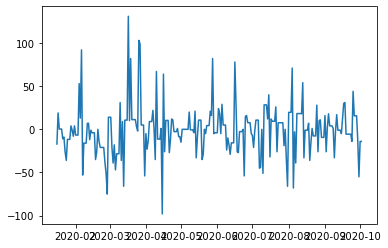

In [92]:
plt.plot(T_yamagata['diff'], label = 'yamagata')
plt.savefig('yamagata.png')

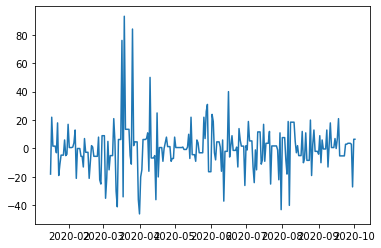

In [93]:
plt.plot(T_ehime['diff'], label = 'ehime')
plt.savefig('ehime.png')

# covid

In [94]:
data=pd.read_csv("program/covid19_pref_20200421.csv")

In [95]:
iwate = data['岩手県']
dateTimeIndex = pd.DatetimeIndex(data['date'])
iwate.index = dateTimeIndex
#plt.plot(iwate, label = 'C-iwate')
#plt.plot(T_iwate['diff'], label = 'S-iwate')
#plt.legend(loc='best')
#plt.show()

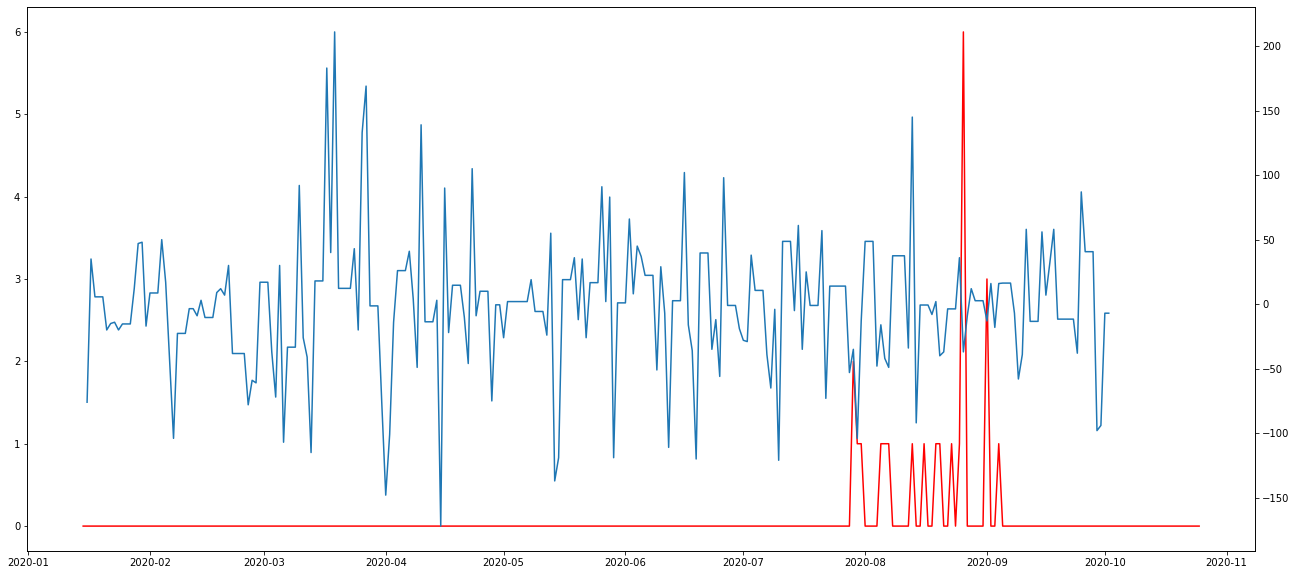

In [96]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(iwate, label = 'C-iwate',color = 'r')
ln2=ax2.plot(T_iwate['diff'], label = 'S-iwate')
plt.savefig('C-T iwate.png')

In [97]:
tottori = data['鳥取県']
dateTimeIndex = pd.DatetimeIndex(data['date'])
tottori.index = dateTimeIndex
#plt.plot(tottori, label = 'tottori')
#plt.legend(loc='best')
#plt.show()

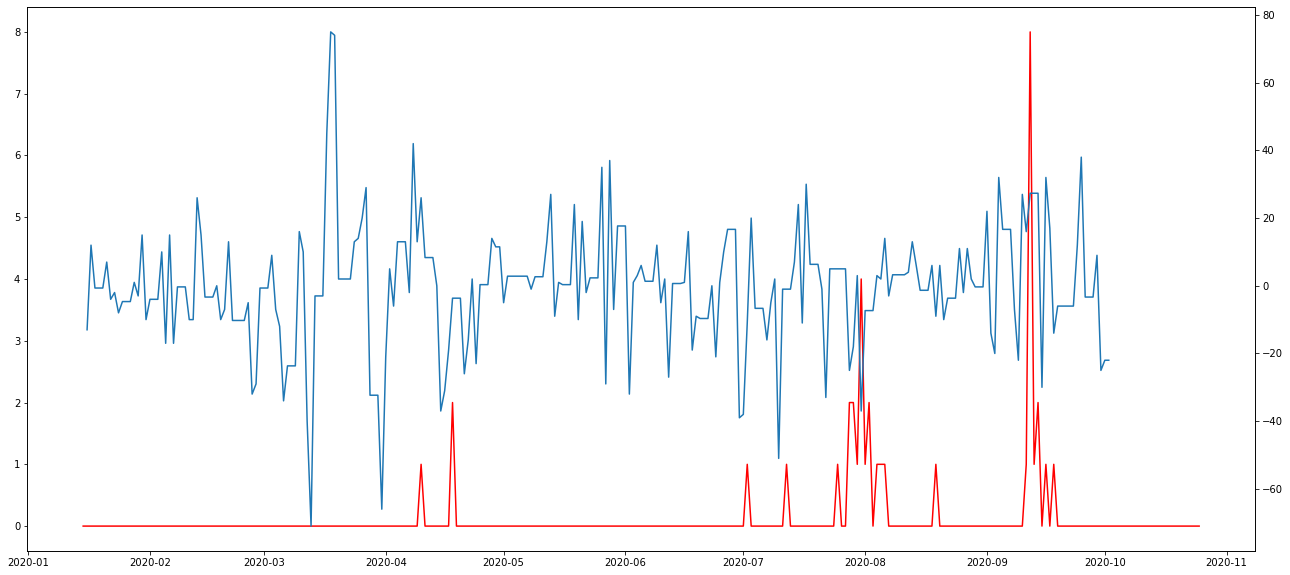

In [98]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(tottori, label = 'C-tottori',color = 'r')
ln2=ax2.plot(T_tottori['diff'], label = 'S-tottori')
plt.savefig('C-T tottori.png')

In [99]:
akita = data['秋田県']
dateTimeIndex = pd.DatetimeIndex(data['date'])
akita.index = dateTimeIndex
#plt.plot(akita, label = 'akita')
#plt.legend(loc='best')
#plt.show()

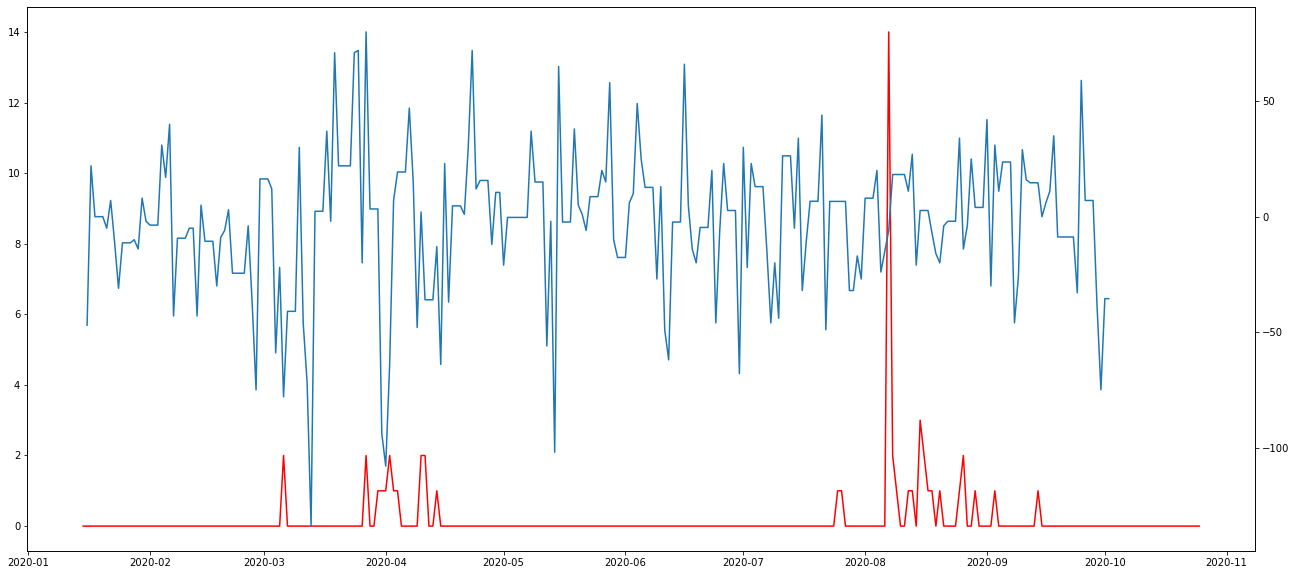

In [100]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(akita, label = 'C-akita',color = 'r')
ln2=ax2.plot(T_akita['diff'], label = 'S-akita')
plt.savefig('C-T akita.png')

In [101]:
yamagata = data['山形県']
dateTimeIndex = pd.DatetimeIndex(data['date'])
yamagata.index = dateTimeIndex
#plt.plot(yamagata, label = 'yamagata')
#plt.legend(loc='best')
#plt.show()

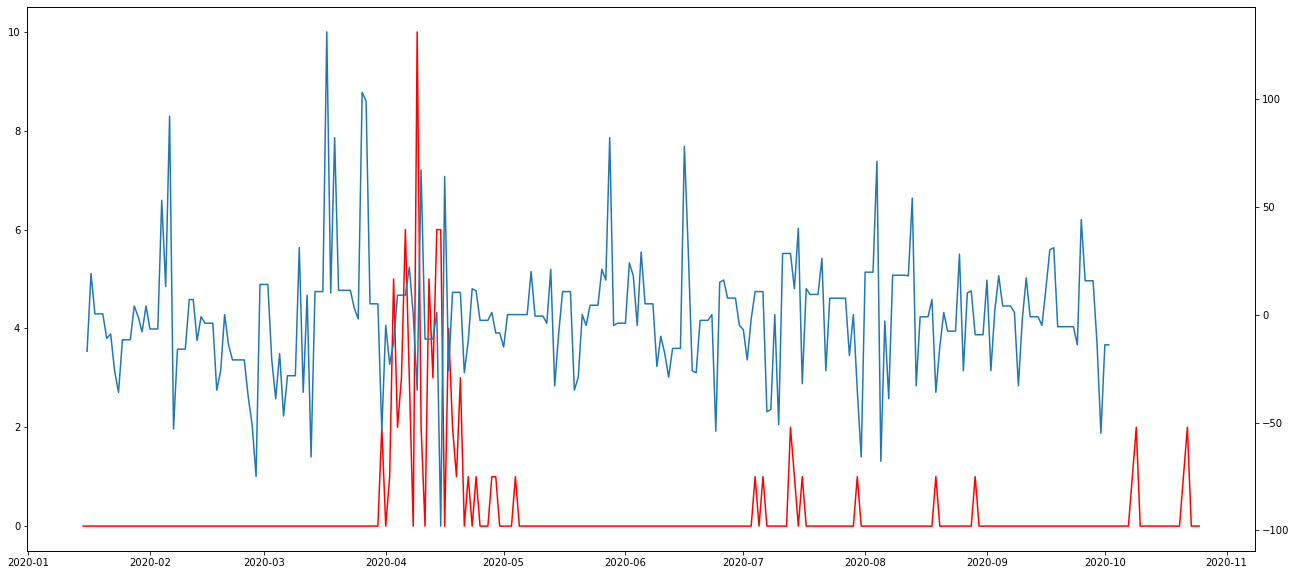

In [102]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(yamagata, label = 'C-yamagata',color = 'r')
ln2=ax2.plot(T_yamagata['diff'], label = 'S-yamagata')
plt.savefig('C-T yamagata.png')

In [103]:
ehime = data['愛媛県']
dateTimeIndex = pd.DatetimeIndex(data['date'])
ehime.index = dateTimeIndex
#plt.plot(ehime, label = 'ehime')
#plt.legend(loc='best')
#plt.show()

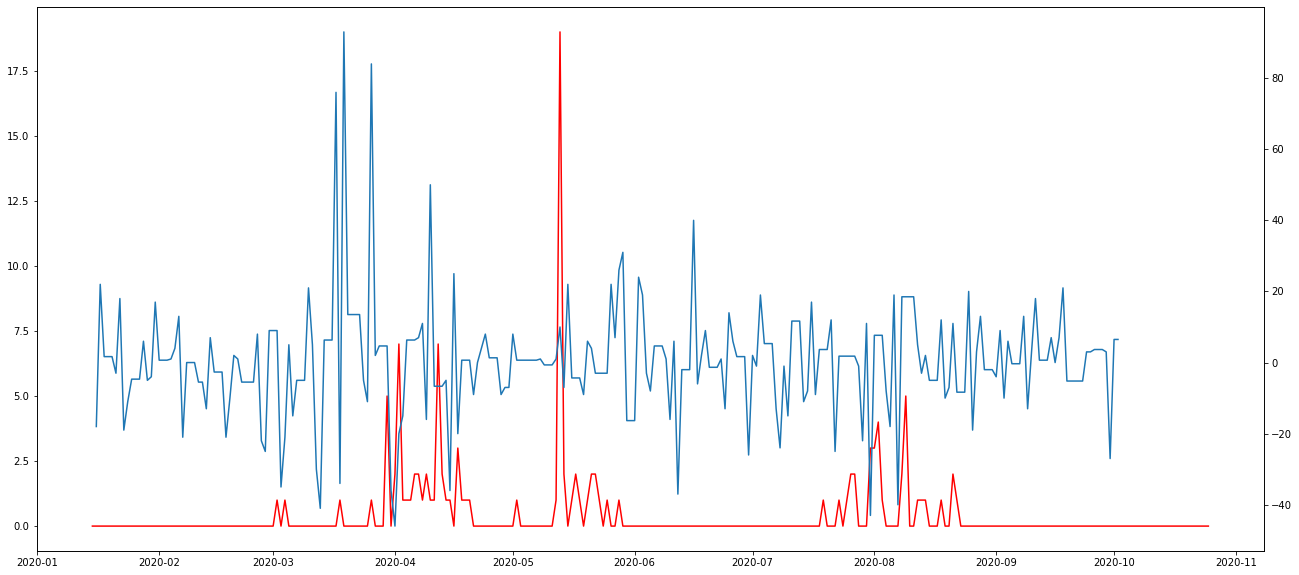

In [104]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(ehime, label = 'C-ehime',color = 'r')
ln2=ax2.plot(T_ehime['diff'], label = 'S-ehime')
plt.savefig('C-T ehime.png')

In [105]:
s_iwate = (S_iwate['指数移動平均(30)'])
s_iwate.index = TimeIndex
s_iwate = s_iwate.replace(np.nan, '0')
s_iwate  = s_iwate.astype(float)
s_iwate = s_iwate['2020-01-14':'2020-10-02']

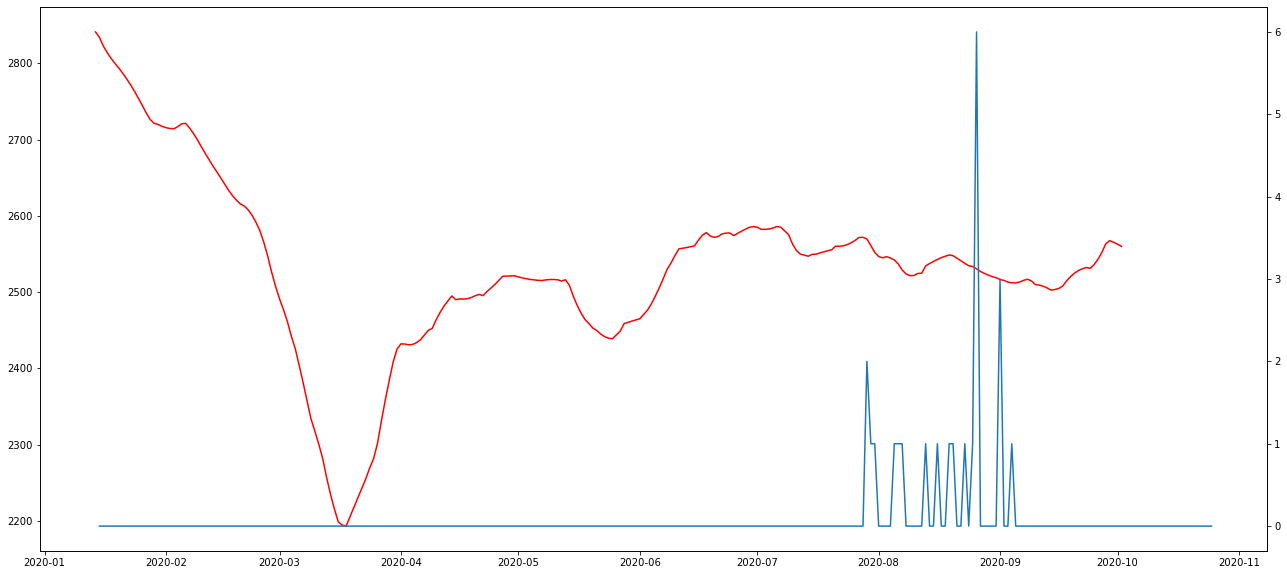

In [106]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(s_iwate, label = 's-iwate',color = 'r')
ln2=ax2.plot(iwate, label = 'C-iwate')
plt.savefig('C-S iwate.png')

In [107]:
s_tottori = (S_tottori['指数移動平均(30)'])
s_tottori.index = TimeIndex
s_tottori = s_tottori.replace(np.nan, '0')
s_tottori  = s_tottori.astype(float)
s_tottori = s_tottori['2020-01-14':'2020-10-02']

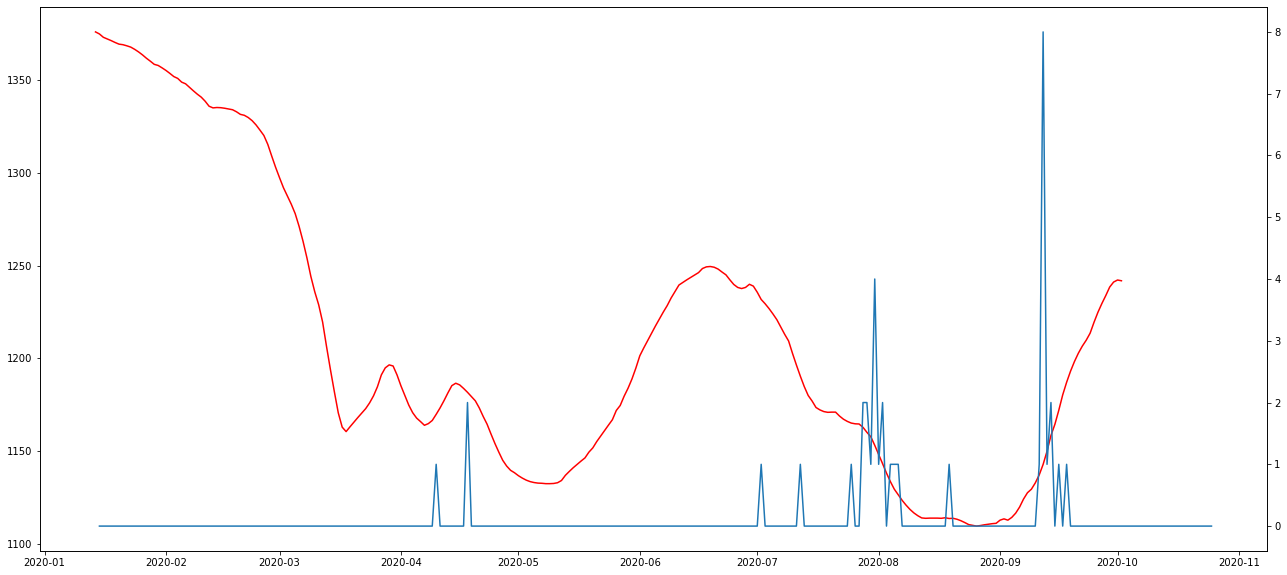

In [108]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(s_tottori, label = 's-tottori',color = 'r')
ln2=ax2.plot(tottori, label = 'C-tottori')
plt.savefig('C-S tottori.png')

In [109]:
s_akita = (S_akita['指数移動平均(30)'])
s_akita.index = TimeIndex
s_akita = s_akita.replace(np.nan, '0')
s_akita  = s_akita.astype(float)
s_akita = s_akita['2020-01-14':'2020-10-02']

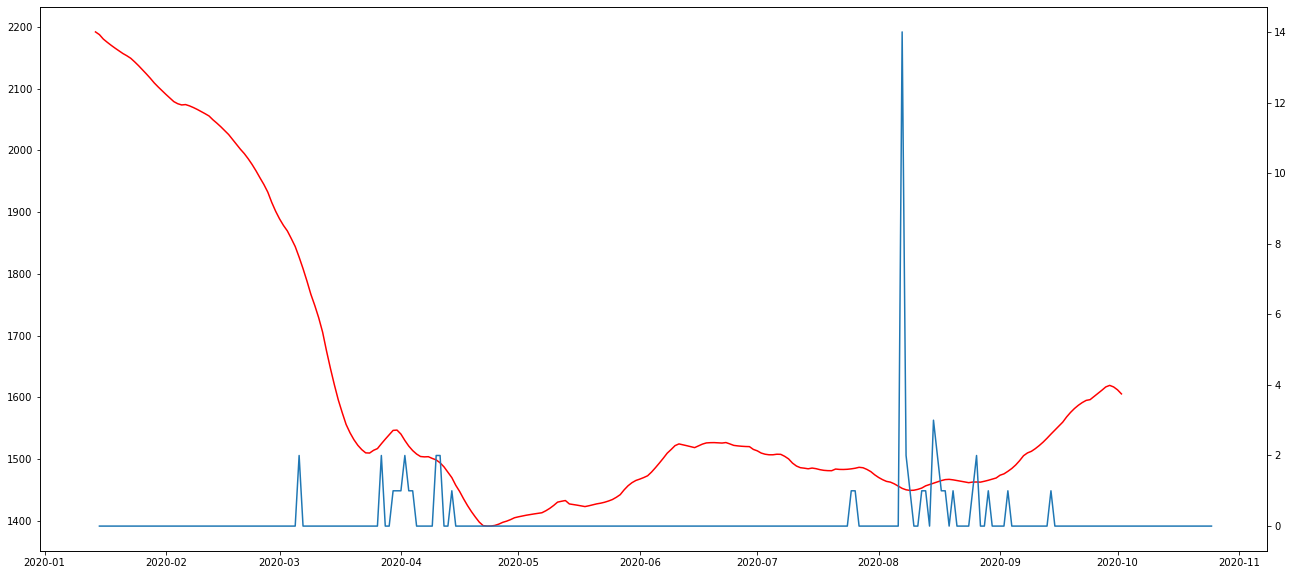

In [110]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(s_akita, label = 's-akita',color = 'r')
ln2=ax2.plot(akita, label = 'C-akita')
plt.savefig('C-S akita.png')

In [111]:
s_yamagata = (S_yamagata['指数移動平均(30)'])
s_yamagata.index = TimeIndex
s_yamagata = s_yamagata.replace(np.nan, '0')
s_yamagata  = s_yamagata.astype(float)
s_yamagata = s_yamagata['2020-01-14':'2020-10-02']

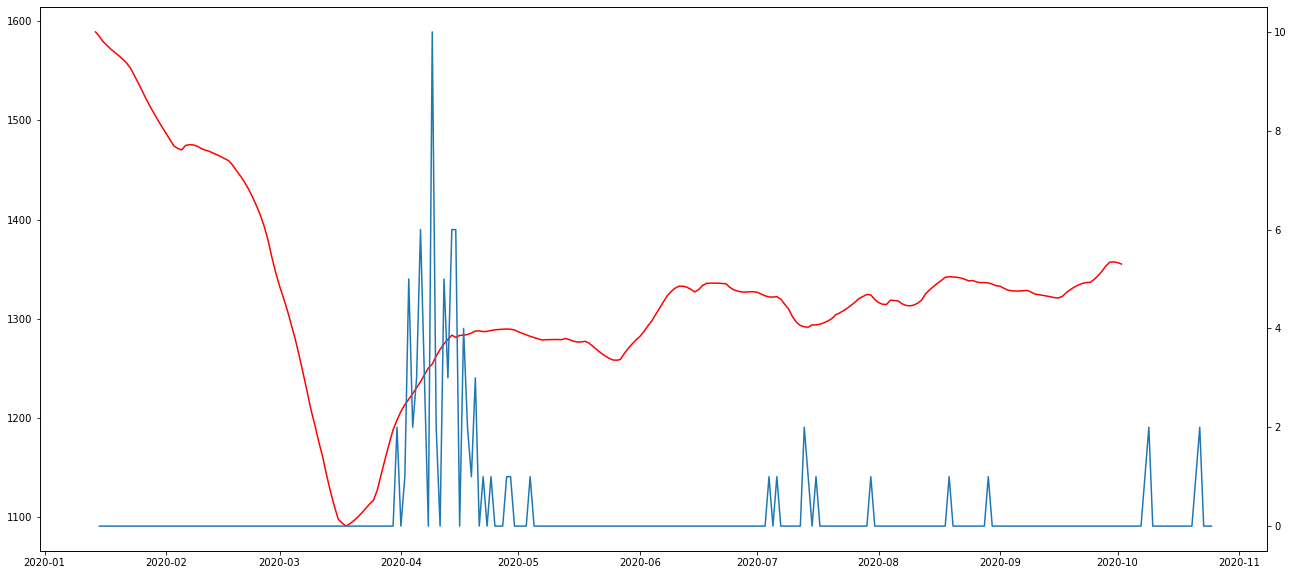

In [112]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(s_yamagata, label = 's-yamagata',color = 'r')
ln2=ax2.plot(yamagata, label = 'C-yamagata')
plt.savefig('C-S yamagata.png')

In [113]:
s_ehime = (S_ehime['指数移動平均(30)'])
s_ehime.index = TimeIndex
s_ehime = s_ehime.replace(np.nan, '0')
s_ehime  = s_ehime.astype(float)
s_ehime = s_ehime['2020-01-14':'2020-10-02']

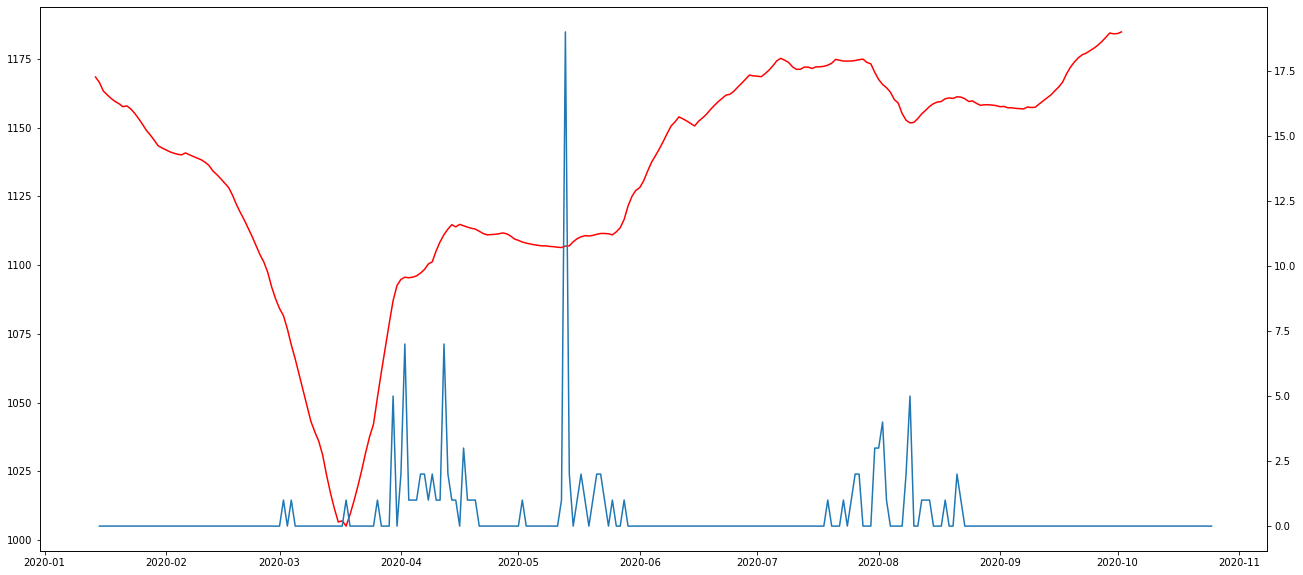

In [114]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(s_ehime, label = 's-ehime',color = 'r')
ln2=ax2.plot(ehime, label = 'C-ehime')
plt.savefig('C-S ehime.png')